In [1]:
import sys
sys.path.insert(0, '/gpfs/home/jupark/.local/lib/python3.8/site-packages')

In [2]:
pip install zoish

Defaulting to user installation because normal site-packages is not writeable
  Using cached xgboost-1.7.5-py3-none-manylinux2014_x86_64.whl (200.3 MB)
  Using cached catboost-1.1.1-cp38-none-manylinux1_x86_64.whl (76.6 MB)
  Using cached shap-0.41.0-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (575 kB)
  Using cached prompt_toolkit-3.0.38-py3-none-any.whl (385 kB)
  Using cached scikit_learn-1.2.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.8 MB)
  Using cached scipy-1.10.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.5 MB)
  Using cached pandas-1.5.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.2 MB)
  Using cached click-8.1.3-py3-none-any.whl (96 kB)
  Using cached nox-2022.11.21-py3-none-any.whl (53 kB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently t

In [3]:
from zoish.feature_selectors.shap_selectors import ShapFeatureSelector
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score,f1_score
from feature_engine.imputation import CategoricalImputer, MeanMedianImputer
from category_encoders import OrdinalEncoder
import xgboost
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner


2023-04-25 12:22:22,033 :: numexpr.utils :: Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-04-25 12:22:22,035 :: numexpr.utils :: NumExpr defaulting to 8 threads.


/gpfs/home/jupark/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


2023-04-25 12:22:28,080 :: matplotlib :: matplotlib data path: /opt/applications/python/3.8.3/gnu/lib/python3.8/site-packages/matplotlib/mpl-data
2023-04-25 12:22:28,096 :: matplotlib :: CONFIGDIR=/gpfs/home/jupark/.config/matplotlib
2023-04-25 12:22:28,102 :: matplotlib :: interactive is False
2023-04-25 12:22:28,103 :: matplotlib :: platform is linux
2023-04-25 12:22:28,105 :: matplotlib :: loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_warnings', '_frozen_importlib_external', '_io', 'marshal', 'posix', '_thread', '_weakref', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', '_abc', 'abc', 'io', '_stat', 'stat', '_collections_abc', 'genericpath', 'posixpath', 'os.path', 'os', '_sitebuiltins', '_locale', '_bootlocale', '_distutils_hack', 'types', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib', 'importlib.machinery', 'importlib.abc', '_operator'

In [4]:
data = pd.read_excel("HCM_data.xlsx", sheet_name="Data")

In [5]:
data

,Center,No,PtNumber,Age,Male,BMI,FHX_SCD,Syncope,Apical,Max_LVwall,...,VHD,Cancer,Event_MACE,Event_MACE_date,Event_Death,Event_Death_date,Event_HFadm,Event_HFadm_date,Event_Stroke,Event_Stroke_date
0,1,1,8071873,64.835616,0,26.672763,0,0,1,22.0,...,0,0,0,2056.0,0,2056.0,0,2056.0,0,2056.0
1,1,2,8707158,52.279452,0,23.011177,0,0,0,17.0,...,0,0,0,3950.0,0,3950.0,0,3950.0,0,3950.0
2,1,3,9289398,54.408219,1,23.183391,0,1,1,17.5,...,0,0,0,1791.0,0,1791.0,0,1791.0,0,1791.0
3,1,4,12738377,63.610959,0,25.476660,0,0,1,15.8,...,0,0,0,2770.0,0,2770.0,0,2770.0,0,2770.0
4,1,5,13241821,66.090411,0,27.548209,0,0,0,17.7,...,0,1,0,2805.0,0,2805.0,0,2805.0,0,2805.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,2,2107,32343937,49.701370,1,NaN,0,0,0,22.0,...,0,0,0,182.0,0,182.0,0,182.0,0,182.0
2107,2,2108,32420043,69.180822,0,NaN,0,0,0,17.0,...,0,0,0,73.0,0,73.0,0,73.0,0,73.0
2108,2,2109,32448995,65.715068,1,NaN,0,0,1,16.0,...,0,0,0,34.0,0,34.0,0,34.0,0,34.0
2109,2,2110,32470497,66.197260,1,NaN,0,0,1,16.0,...,0,0,0,115.0,0,115.0,0,115.0,0,115.0


In [6]:
data.isna().sum()

Center                 0
No                     0
PtNumber               0
Age                    0
Male                   0
BMI                  195
FHX_SCD                0
Syncope                0
Apical                 0
Max_LVwall             0
MaxLVOTGr              0
LAsize                23
LVIDd                 18
LVIDs                 30
LVEDVi               206
LVESVi               216
SVi                  216
EF                     0
E                     17
DT                    75
Medial_e_prime        44
E_e_prime             51
PASP                 307
BB                     0
HTN                    0
DM                     0
Dyslipidemia           0
HF                     0
AF                     0
Stroke                 0
CAD                    0
VHD                    0
Cancer                 0
Event_MACE             0
Event_MACE_date        8
Event_Death            0
Event_Death_date       8
Event_HFadm            0
Event_HFadm_date       8
Event_Stroke           0


In [7]:
#External feature and target arrays
X, y = data.drop(['No', 'PtNumber', 'Event_MACE', 'Event_MACE_date', 'Event_Death', 'Event_Death_date', 'Event_HFadm', 'Event_HFadm_date', 'Event_Stroke', 'Event_Stroke_date'], axis=1), data[['Center', 'Event_MACE']]

In [8]:
X1 = X[X['Center'] <2]

In [9]:
X2 = X[X['Center'] >=2]

In [10]:
y1 = y[y['Center'] <2]

In [11]:
y2 = y[y['Center'] >=2]

In [12]:
X_train = X1.drop('Center', axis=1)

In [13]:
X_test = X2.drop('Center', axis=1)

In [14]:
y_train = y1.drop('Center', axis=1)

In [15]:
y_test = y2.drop('Center', axis=1)

In [16]:
y_train.value_counts()

Event_MACE
0             821
1             185
dtype: int64

In [17]:
data.dtypes

Center                 int64
No                     int64
PtNumber               int64
Age                  float64
Male                   int64
BMI                  float64
FHX_SCD                int64
Syncope                int64
Apical                 int64
Max_LVwall           float64
MaxLVOTGr            float64
LAsize               float64
LVIDd                float64
LVIDs                float64
LVEDVi               float64
LVESVi               float64
SVi                  float64
EF                   float64
E                    float64
DT                   float64
Medial_e_prime       float64
E_e_prime            float64
PASP                 float64
BB                     int64
HTN                    int64
DM                     int64
Dyslipidemia           int64
HF                     int64
AF                     int64
Stroke                 int64
CAD                    int64
VHD                    int64
Cancer                 int64
Event_MACE             int64
Event_MACE_dat

In [18]:
int_cols =  X_train.select_dtypes(include=['int']).columns.tolist()
float_cols =  X_train.select_dtypes(include=['float']).columns.tolist()
cat_cols =  X_train.select_dtypes(include=['object']).columns.tolist()

In [19]:
shap_feature_selector_factory = (
    ShapFeatureSelector.shap_feature_selector_factory.set_model_params(
        X=X_train,
        y=y_train,
        verbose=10,
        random_state=0,
        estimator=xgboost.XGBClassifier(),
        estimator_params={
            "max_depth": [4, 20],
            "n_estimators": [100, 2000],
            "gamma": [0.01, 10],
            "scale_pos_weight":[4.1,5],

        },
        fit_params = {
            "callbacks": None,
        },
        method="optuna",
        # if n_features=None only the threshold will be considered as a cut-off of features grades.
        # if threshold=None only n_features will be considered to select the top n features.
        # if both of them are set to some values, the threshold has the priority for selecting features.
        n_features=8,
        threshold = None,
        list_of_obligatory_features_that_must_be_in_model=[],
        list_of_features_to_drop_before_any_selection=[],
    )
    .set_shap_params(
        model_output="raw",
        feature_perturbation="interventional",
        algorithm="v2",
        shap_n_jobs=-1,
        memory_tolerance=-1,
        feature_names=None,
        approximate=False,
        shortcut=False,
    )
    .set_optuna_params(
            measure_of_accuracy="roc_auc_score(y_true, y_pred)",
            # optuna params
            with_stratified=False,
            test_size=.3,
            n_jobs=-1,
            # optuna params
            # optuna study init params
            study=optuna.create_study(
                storage=None,
                sampler=TPESampler(),
                pruner=HyperbandPruner(),
                study_name="example of optuna optimizer",
                direction="maximize",
                load_if_exists=False,
                directions=None,
            ),
            # optuna optimization params
            study_optimize_objective=None,
            study_optimize_objective_n_trials=100,
            study_optimize_objective_timeout=600,
            study_optimize_n_jobs=-1,
            study_optimize_catch=(),
            study_optimize_callbacks=None,
            study_optimize_gc_after_trial=False,
            study_optimize_show_progress_bar=False,
            )
)

[I 2023-04-25 12:22:42,576] A new study created in memory with name: example of optuna optimizer


In [20]:
pipeline =Pipeline([
            # int missing values imputers
            ('intimputer', MeanMedianImputer(
                imputation_method='median', variables=int_cols)),
            ('floatimputer', MeanMedianImputer(
                imputation_method='mean', variables=float_cols)),
            # category missing values imputers
            # ('catimputer', CategoricalImputer(variables=cat_cols)),
            #
            # ('catencoder', OrdinalEncoder()),
            # feature selection
            ("sfsf", shap_feature_selector_factory),
            # add any regression model from sklearn e.g., LinearRegression
            ('classification', xgboost.XGBClassifier())


 ])

In [21]:
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)

2023-04-25 12:22:42,632 :: root :: Building Best Estimator by Optuna !


`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
[I 2023-04-25 12:22:45,429] Trial 4 finished with value: 0.8828356980610331 and parameters: {'max_depth': 4, 'n_estimators': 342, 'gamma': 3.8982400360958067, 'scale_pos_weight': 4.5364041075980195}. Best is trial 4 with value: 0.8828356980610331.
[I 2023-04-25 12:22:47,128] Trial 13 finished with value: 0.9074628831023472 and parameters: {'max_depth': 16, 'n_estimators': 228, 'gamma': 3.9118372436235673, 'scale_pos_weight': 4.7582954405580145}. Best is trial 13 with value: 0.9074628831023472.
[I 2023-04-25 12:22:48,331] Trial 1 finished with value: 0.8904105079500939 and parameters: {'max_depth': 5, 'n_estimators': 575, 'gamma': 4.3119423166091035, 'scale_pos_weight': 4.952567092725413}. Best is trial 13 with value: 0.9074628831023472.
[I 2023-04-25 12:22:48,441] Trial 10 finished with value: 0.8797149158903117 and parameters: {'max_depth':

2023-04-25 12:25:15,777 :: root :: type of plot is : summary_plot


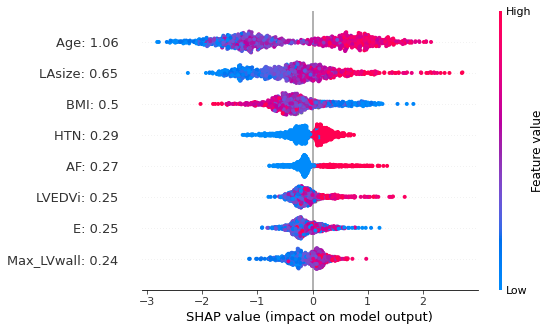

ShapFeatureSelector(X=            Age  Male        BMI  FHX_SCD  Syncope  Apical  Max_LVwall  \
0     64.835616     0  26.672763        0        0       1        22.0   
1     52.279452     0  23.011177        0        0       0        17.0   
2     54.408219     1  23.183391        0        1       1        17.5   
3     63.610959     0  25.476660        0        0       1        15.8   
4     66.090411     0  27.548209        0        0       0        17.7   
...         ...   ...        ...      ...      ...     ...         ...   
1001  80.515068     1  23.624447        0        0       0        15.0   
1002  73.994521     1  24.158818        0        0       0        19.0   
1003  82.071233     0  25.429116        0        0       1        17.0   
1004  59.389041     1  24.167162        1        0       1        20.0   
1005  46.7...
                    study=<optuna.study.study.Study object at 0x7f8009fe51f0>,
                    study_optimize_catch=(),
                    study_optimize_gc_after_trial=False,
                    study_optimize_n_jobs=-1,
                    study_optimize_objective_n_trials=100,
                    study_optimize_objective_timeout=600,
                    study_optimize_show_progress_bar=False, test_size=0.3,
                    verbose=10,
                    y=      Event_MACE
0              0
1              0
2              0
3              0
4              0
...          ...
1001           0
1002           0
1003           0
1004           0
1005           0

[1006 rows x 1 columns])

In [22]:
ShapFeatureSelector.shap_feature_selector_factory.plot_features_all(
    type_of_plot="summary_plot",
    path_to_save_plot="./shap_optuna_search_regression_summary_plot"
)

In [23]:
print('f1 score : ')
print(f1_score(y_test,y_pred))

f1 score : 
0.21722846441947566


In [24]:
print('auc score : ')
print(roc_auc_score(y_test,y_pred))

auc score : 
0.5497453459782227
